## 確率分布

[clgplot](https://github.com/masatoi/clgplot)を使っています。


In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
(ql:quickload `(:cl-waffe :clgplot) :silent t)

T

(:CL-WAFFE :CLGPLOT)

Unable to find framework CUDA


In [2]:
(defpackage :distribution-example
    (:use :cl :cl-waffe :clgplot :mgl-mat))

(in-package :distribution-example)

#<PACKAGE "DISTRIBUTION-EXAMPLE">

#<PACKAGE "DISTRIBUTION-EXAMPLE">

In [3]:
#+sbcl(declaim (sb-ext:muffle-conditions sb-kernel:redefinition-warning))

((#<SB-KERNEL::CONDITION-CLASSOID SB-KERNEL:REDEFINITION-WARNING>
  . MUFFLE-WARNING))

SB-INT:SIMPLE-STYLE-WARNING: DECLAIM where DECLARE was probably intended


In [4]:
; Utils

(defparameter *output-dir* nil)

(defmacro with-gnuplot (title &body body)
    `(let ((*output-dir* (format nil "./tmp/~a.png" ,title)))
          (locally ,@body)
          (jupyter:file *output-dir* :display t)))

(defun show-tensor (samples pdf &key (sample-n 30) (title "tmp"))
    "samples : サンプリングされた確率分布
     PDF     : 確率密度関数"
    (declare (type waffetensor samples)
             (type function pdf))
    (with-facets ((a* ((data samples) 'array)))
        (plot-histogram-with-pdf
         (coerce a* 'list)
         sample-n
         pdf
         :output *output-dir*)))

*OUTPUT-DIR*

WITH-GNUPLOT

SHOW-TENSOR

SB-INT:SIMPLE-STYLE-WARNING: The variable TITLE is defined but never used.


## 正規分布

確率密度関数 (σは分散, μは平均) ここではσ=1.0, μ=0.0とする。

$$
f(x)=\dfrac{1}{\sqrt{2\pi\sigma^2}}\exp(-\dfrac{(x-\mu)^ 2}{2\sigma^ 2})
$$

In [5]:

; single-floatで計算する
(defparameter pi-single-float (coerce pi 'single-float))

; 正規分布の確率密度関数
(defun standard-distribution (x &key (mean 0.0) (var 1.0))
    (declare (optimize (speed 3))
             (type single-float x mean var))
    (* (/ (sqrt (* 2 pi-single-float (expt var 2))))
       (exp (- (/ (expt (- x mean) 2) (* 2 (expt var 2)))))))

PI-SINGLE-FLOAT

STANDARD-DISTRIBUTION

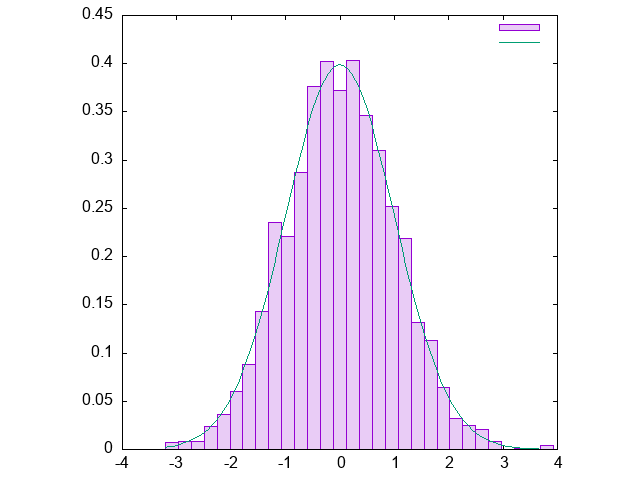

In [6]:
(with-gnuplot "randn"
    (show-tensor (!randn `(3000))
                 #'standard-distribution))

## ベータ分布

確率密度関数

$$
f(x;\alpha,\beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)} \quad \text{where} \quad x \in [0, 1]
$$

$$
B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

In [7]:
(defun lanczos-gamma (x)
  (let* ((coefficients #(57.1562356658629235d0
                         -59.5979603554754912d0
                         14.1360979747417471d0
                         -0.491913816097620199d0
                         0.339946499848118887d-4
                         0.465236289270485756d-4
                         -0.983744753048795646d-4
                         0.158088703224912494d-3
                         -0.210264441724104883d-3
                         0.217439618115212643d-3
                         -0.164318106536763890d-3
                         0.844182239838527433d-4
                         -0.261908384015814087d-4))
         (g (/ 607.0d0 128.0d0))
         (sum 0.0d0))
    (dotimes (i (length coefficients))
      (setq sum (+ sum (* (aref coefficients i) (expt (+ x 0.5d0) (- i 1))))))
    (* (sqrt (* 2 pi)) (/ sum (expt x g)) (expt x (+ 0.5d0 (/ 1 12d0))))))

(defun gamma-fn (x)
  (if (< x 1.0d0)
      (/ (gamma-fn (+ x 1)) x)
      (- (lanczos-gamma x) (expt x -1))))

(defun beta-fn (a b)
  "Compute the beta function of a and b."
  (/ (gamma-fn a) (gamma-fn b) (gamma-fn (+ a b))))

(defun beta-pdf (x a b)
  "Compute the probability density function of the beta distribution for x with parameters a and b."
  (if (or (< x 0) (> x 1))
    (error "x must be in the range [0, 1].")
    (* (/ (expt x (- a 1)) (expt (- 1 x) (- b 1))) (/ 1 (beta-fn a b)))))

LANCZOS-GAMMA

GAMMA-FN

BETA-FN

BETA-PDF

ALPHA

BETA

BETA-PDF-X

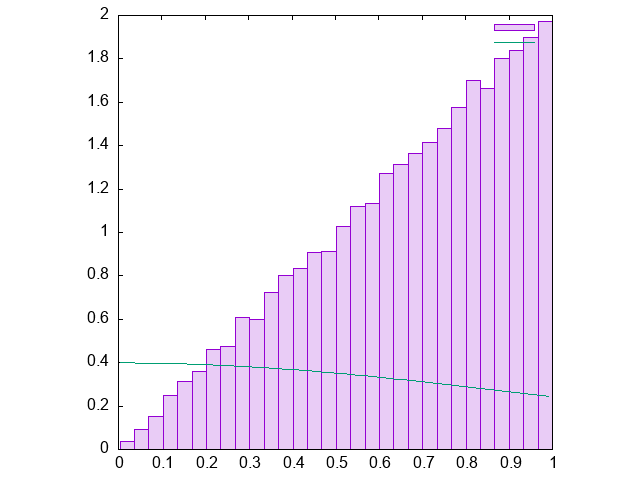

In [8]:
(defparameter alpha 2.0)
(defparameter beta 1.0)

(defun beta-pdf-x (x)
    (beta-pdf x alpha beta))

(with-gnuplot "Beta"
    (show-tensor (!beta `(30000) alpha beta) #'standard-distribution)) ; Todo: beta pdf